<a href="https://colab.research.google.com/github/Samarth1302/IntrusionDetection/blob/main/Intrusion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and Data loading

Importing libraries

In [ ]:
import numpy as np 
import os
import pandas as pd 
import time
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Importing dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
low_memory=False
df1 = pd.read_csv("drive/MyDrive/ML_dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
df2=pd.read_csv("drive/MyDrive/ML_dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
df3=pd.read_csv("drive/MyDrive/ML_dataset/Friday-WorkingHours-Morning.pcap_ISCX.csv")
df4=pd.read_csv("drive/MyDrive/ML_dataset/Monday-WorkingHours.pcap_ISCX.csv")
df5=pd.read_csv("drive/MyDrive/ML_dataset/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
df6=pd.read_csv("drive/MyDrive/ML_dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
df7=pd.read_csv("drive/MyDrive/ML_dataset/Tuesday-WorkingHours.pcap_ISCX.csv")
df8=pd.read_csv("drive/MyDrive/ML_dataset/Wednesday-workingHours.pcap_ISCX.csv")

Concatenating dataframes

In [ ]:
nRowsRead = None 
df = pd.concat([df1,df2])
del df1,df2
df = pd.concat([df,df3])
del df3
df = pd.concat([df,df4])
del df4
df = pd.concat([df,df5])
del df5
df = pd.concat([df,df6])
del df6
df = pd.concat([df,df7])
del df7
df = pd.concat([df,df8])
del df8
df.shape

(2830743, 79)

#Data cleaning and pre-processing

Removing duplicates

In [ ]:
df[' Label'].value_counts()

BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name:  Label, dtype: int64

In [ ]:
df.duplicated().sum()

308381

In [ ]:
df = df.drop_duplicates(keep="first")

In [ ]:
df.duplicated().sum()

0

Removing null values

In [ ]:
df.isnull().sum().sort_values(ascending = False)

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isnull().sum().sort_values(ascending = False)

Removing classes with less than 10,000 rows

In [ ]:
df=df.groupby(' Label').filter(lambda x:len(x)>10000)
df[' Label'].value_counts()

BENIGN           2096134
DoS Hulk          172846
DDoS              128016
PortScan           90819
DoS GoldenEye      10286
Name:  Label, dtype: int64

Reducing Memory usage by downcasting

In [ ]:
integer = []
f = []
for i in df.columns[:-1]:
    if df[i].dtype == "int64": integer.append(i)
    else : f.append(i)

df[integer] = df[integer].astype("int32")
df[f] = df[f].astype("float32")

In [ ]:
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)]

# Correlation

Finding correlation between features

In [ ]:
def correlation(dataset, threshold):
    col_corr = set()  
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
              colname = corr_matrix.columns[i]                  
              col_corr.add(colname)
    return col_corr

In [ ]:
corr_features = correlation(df, 0.85)
corr_features

In [ ]:
# sns.heatmap(df.corr(), cmap='crest')

Removing highly correlated features

In [ ]:
df.drop(corr_features,axis=1,inplace=True)

In [ ]:
plt.figure(figsize=(20,10), facecolor='w')
sns.boxplot(data=df)
plt.show()

In [ ]:
x = df.drop([' Label'],axis=1)
y = df[' Label']

In [ ]:
x.head()

# Undersampling

Using undersampling to balance data and remove bias

In [ ]:
rus = RandomUnderSampler(random_state=0)
rus.fit(x, y)
Xn, yn = rus.fit_resample(x, y)

In [ ]:
Xn.head()
Xn.shape

(51430, 41)

# PCA for dimensionality reduction

In [ ]:
# from sklearn.feature_selection import VarianceThreshold
# constant_filter = VarianceThreshold(threshold=0)
# constant_filter.fit(Xn)
# constant_filter.get_support()
# constant_columns = [column for column in Xn.columns if column not in Xn.columns[constant_filter.get_support()]]
# Xn = Xn.drop(constant_columns,axis=1)
# print(constant_columns)
# Xn.shape


X_std_pca = np.empty((51430,41))
def myPCA(nn):

  from sklearn import decomposition, datasets
  from sklearn.preprocessing import StandardScaler

  std_slc = StandardScaler()
  X_std = std_slc.fit_transform(Xn)
  
  pca = decomposition.PCA(n_components=nn)
  X_std_pca = pca.fit_transform(X_std)

# ANOVA to choose k-best features

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
def select_features(X_train, y_train, X_test,n_features):
  fs = SelectKBest(score_func=f_classif, k=n_features)
  fs.fit(X_train, y_train)
  X_train_fs = fs.transform(X_train)
  X_test_fs = fs.transform(X_test)
  return X_train_fs, X_test_fs, fs

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Xn, yn, test_size=0.30, random_state=1)

In [ ]:
org_X_train = X_train
org_X_test = X_test

# Plot confusion matrix

In [ ]:
def plot_confusion_matrix(cm,title,cmap=None,target=None,normalize=False):

    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('viridis')
    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target is not None:
        ticks = np.arange(len(target))
        plt.xticks(ticks, target, rotation=45)
        plt.yticks(ticks, target)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "white")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "white")
    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title, bbox_inches='tight', dpi=300)

# KNN algorithm

In [ ]:
precisionkNN = []
def kNN(neighbours):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test=train_test_split(X_std_pca,yn,random_state=30)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    from sklearn import metrics
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import cross_val_score

    
    KNN_Classifier = KNeighborsClassifier(n_jobs=-1, n_neighbors=neighbours, metric='minkowski', algorithm='auto')
    KNN_Classifier.fit(X_train, y_train); 
    # print("Time taken to train kNN model", time.time()-startKNN, " seconds")

    Predict_x=KNN_Classifier.predict(X_train)
    scores = cross_val_score(KNN_Classifier, X_train, y_train, cv=4)
    accuracy = metrics.accuracy_score(y_train,Predict_x)
    confusion_matrix = metrics.confusion_matrix(y_train,Predict_x)
    classification = metrics.classification_report(y_train, Predict_x)

    startKNN = time.time()
    Predict_x=KNN_Classifier.predict(X_test)
    scores = cross_val_score(KNN_Classifier, X_test, y_test, cv=4)
    accuracy = metrics.accuracy_score(y_test,Predict_x)
    confusion_matrix = metrics.confusion_matrix(y_test,Predict_x)
    classification = metrics.classification_report(y_test, Predict_x)
    plot_confusion_matrix(cm=confusion_matrix ,title= 'k-Nearest Neighbours Classification')
    print("Time taken for execution: ", time.time()-startKNN, " seconds")
    
    print()
    print('-------------------------- Result ----------------------')
    print()
    print("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()


    precisionkNN.append(accuracy)

#Random Forest model

In [ ]:
accuracy=0
# timetaken=time.time()
precision=[]
def RandomForest():
  from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
  X_train, X_test, Y_train, Y_test = train_test_split(X_std_pca,yn,test_size=0.30,random_state=0)

  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  from sklearn.model_selection import cross_val_score
  from sklearn.ensemble import RandomForestClassifier as RFC

  
  Random_Forest = RFC(max_depth=40) 
  Random_Forest.fit(X_train, Y_train) 

  
  # print("Time taken to train model =",timetaken)
  Predict_X =  Random_Forest.predict(X_train)
  scores = cross_val_score(Random_Forest, X_train, Y_train, cv=7)
  accuracy = metrics.accuracy_score(Y_train,Predict_X)
  confusion_matrix = metrics.confusion_matrix(Y_train, Predict_X)
  classification = metrics.classification_report(Y_train, Predict_X)

  start = time.time()
  

  Predict_X =  Random_Forest.predict(X_test)
  scores = cross_val_score(Random_Forest, X_test, Y_test, cv=7)
  accuracy = metrics.accuracy_score(Y_test,Predict_X)
  confusion_matrix = metrics.confusion_matrix(Y_test, Predict_X)
  classification = metrics.classification_report(Y_test, Predict_X)
  plot_confusion_matrix(cm=confusion_matrix ,title= 'Random Forest Classification')
  timetaken=time.time()-start
  print("Time taken for execution = ",timetaken)
  print()
  print('-------------------------- Result ----------------------')
  print()
  print("Cross Validation Mean Score:" "\n", scores.mean())
  print()
  print("Model Accuracy:" "\n", accuracy)
  print()
  print("Confusion matrix:" "\n", confusion_matrix)
  print()
  print("Classification report:" "\n", classification) 
  print()
  precision.append(accuracy)

#Gaussian Naive Bayes

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Xn, yn, test_size = 0.3, random_state = 0)

In [ ]:
scaler  =  StandardScaler () 
X_train  =  scaler . fit_transform ( X_train ) 
X_test  =  scaler . transform ( X_test )

In [ ]:
startGNB = time.time()
gnb = GaussianNB()

# fit the model
gnb.fit(X_train, y_train)

GaussianNB()

In [ ]:
y_pred = gnb.predict(X_test)
timetaken = time.time()-startGNB

In [ ]:
precision_gnb = []
def GNB():
  X_train, X_test, y_train, y_test = train_test_split(X_std_pca, yn, test_size = 0.3, random_state = 0)

  scaler = StandardScaler() 
  X_train = scaler.fit_transform(X_train) 
  X_test = scaler.transform(X_test)

  startGNB = time.time()
  gnb = GaussianNB()
  gnb.fit(X_train, y_train)
  y_pred = gnb.predict(X_test)
  timetaken = time.time()-startGNB
  accuracy = metrics.accuracy_score(y_test,y_pred)
  precision_gnb.append(accuracy)

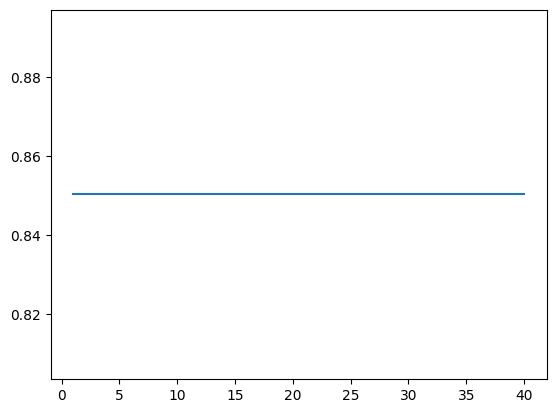

In [ ]:
num_feat = [40,35,30,25,20,15,10,5,3,1]

for i in num_feat:
  myPCA(i)
  GNB()
  

plt.plot(num_feat,precision_gnb)
plt.show()

In [ ]:
accuracy = metrics.accuracy_score(y_test,y_pred)
confusion_matrix = metrics.confusion_matrix(y_test,y_pred)
classification = metrics.classification_report(y_test, y_pred)
plot_confusion_matrix(cm=confusion_matrix ,title= 'Gaussian Naive Bayes Classification')
scores = cross_val_score(gnb, X_train, y_train, cv=4)
print("Time taken for execution: ", timetaken, " seconds")

print()
print('-------------------------- Result ----------------------')
print()
print("Cross Validation Mean Score:" "\n", scores.mean())
print()
print("Model Accuracy:" "\n", accuracy)
print()
print("Confusion matrix:" "\n", confusion_matrix)
print()
print("Classification report:" "\n", classification) 
print()

# Execution and results

In [ ]:
for i in [20,15,10,5,3]:
  X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test,i)
  kNN(3)

[0.9653250372674833, 0.9718711517272668, 0.9613066303713785, 0.9512606131311168, 0.9428349212521875]


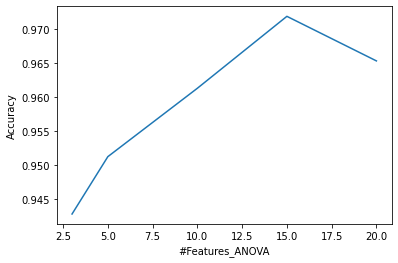

In [ ]:
print(precisionkNN)
feature_cnt=[20,15,10,5,3]
plt.plot(feature_cnt,precisionkNN)
plt.xlabel("#Features_ANOVA")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# myPCA(20)
# #kNN()
# precisionkNN = []

# for i in [20,15,10,5,3]:
#   print("Number of features =",i)
#   kNN(i)

[0.9901228806968424, 0.9912894695909161, 0.9926893762638046, 0.9947114636801991, 0.9955669622025198]


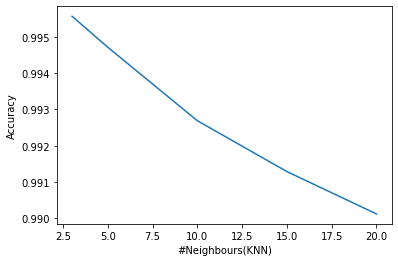

In [ ]:
print(precisionkNN)
feature_cnt=[20,15,10,5,3]
plt.plot(feature_cnt,precisionkNN)
plt.xlabel("#Neighbours(KNN)")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
print("Without PCA")
kNN(3)
print("Accuracy without PCA: ",precisionkNN[0])
precisionkNN = []

for i in [40,35,30,25,20,15,10,5,3,2,1]:
  print("Number of features =",i)
  myPCA(i)
  kNN(3)

In [ ]:
print(precisionkNN)

[0.6585783170010888, 0.6585783170010888, 0.6585783170010888, 0.6585783170010888, 0.6585783170010888, 0.6585783170010888, 0.6585783170010888, 0.6585783170010888, 0.6585783170010888, 0.6585783170010888, 0.6585783170010888]


In [ ]:
# print(precisionkNN)
# feature_cnt=[40,35,30,25,20,15,10,5,3,2,1]
# plt.plot(feature_cnt,precisionkNN)
# plt.xlabel("#Features")
# plt.ylabel("Accuracy")
# plt.show()

In [ ]:
myPCA(20)
RandomForest()

In [ ]:
print(precision)
print(precisionkNN)

[0.9990926177976538]
[0.9901228806968424, 0.9912894695909161, 0.9926893762638046, 0.9947114636801991, 0.9955669622025198]



Training and testing model for different number of features

In [ ]:
# print("Without dimensionality reduction")
# RandomForest()
# print("Accuracy without PCA =",precision[0])
# precision=[]

# print("Using PCA")
# for i in [40,35,30,25,20,15,10,5,3,2,1]:
#   print("Number of features =",i)
#   myPCA(i)
#   RandomForest()

Plot for accuracy vs #features

In [ ]:
# print(precision)
# feature_cnt=[40,35,30,25,20,15,10,5,3,2,1]
# plt.plot(feature_cnt,precision)
# plt.xlabel("#Features")
# plt.ylabel("Accuracy")
# plt.show()